In [13]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import argparse
import wrds

In [ ]:
# Connexion à la base de données WRDS
db = wrds.Connection(wrds_username='lilas_bertot')

# Changer le nom après wrds_username pour te connecter, 
# entrer le nom d'utilisateur puis ton mot de passe dans la barre du haut, 
# puis "y" pour ne pas avoir à te reconnecter à chaque fois!


# a) Statistiques descriptives des rendements

In [ ]:
#Paramètres de la VaR: 

TICKER = "LNC"
ALPHA = 0.05
ROLLING_WINDOW = 250
MIN_START = 250
START = "2015-01-01"
END = None 


In [ ]:
# Traitements des données 

def fetch_returns_wrds(ticker: str, start=START, end=END):
   
    import wrds, certifi
    db = wrds.Connection(sslmode="verify-ca", sslrootcert=certifi.where())
    sql = f"""
        SELECT a.date, b.ticker, a.permno, a.ret
        FROM crsp.dsf a
        JOIN crsp.stocknames b
          ON a.permno = b.permno
         AND a.date BETWEEN b.namedt AND COALESCE(b.nameenddt, '9999-12-31')
        WHERE b.ticker = '{ticker}'
          AND a.date >= '{start}'
          {f"AND a.date <= '{end}'" if end else ""}
        ORDER BY a.date
    """
    df = db.raw_sql(sql)
    if df.empty:
        raise ValueError(f"Aucune donnée CRSP pour {ticker}.")
    
    # En cas de multiples permno (fusion, etc), on garde le principal
    counts = df.groupby("permno")["date"].count().sort_values(ascending=False)
    main_permno = counts.index[0]
    df = df[df["permno"] == main_permno].copy()
    
    # Conversion en décimal 
    df = df[["date", "ret"]].rename(columns={"date": "Date", "ret": "Return"})
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.dropna().sort_values("Date")
    df = df.set_index("Date")
    return df["Return"].rename("Rendement")


In [ ]:
# a) Statistiques descriptives des rendements
def statistiques_descriptives(x: pd.Series) -> pd.DataFrame:
    x = x.dropna()
    mean = x.mean()
    std = x.std(ddof=1)
    skew = ((x - mean)**3).mean() / (std**3)
    kurt = ((x - mean)**4).mean() / (std**4) - 3
    return pd.DataFrame({
        "Moyenne": [mean],
        "Écart-type": [std],
        "Asymétrie": [skew],
        "Kurtose (excès)": [kurt]
    })

# Charger les rendements de l'action choisie
rendements, src = charger_rendements(TICKER)

print(f"\n(a) Données utilisées : {TICKER} (source: {src})")
stats = statistiques_descriptives(rendements)
print("(a) Statistiques descriptives :")
print(stats.to_string(index=False))

plt.figure()
rendements.plot()
plt.title(f"{TICKER} – Rendements journaliers ({src})")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.tight_layout()
plt.show()

# b) Calcul de la VaR Historique avec une fenêtre mobile


(b) VaR mobile 5% (250 j) : 89 violations sur 2000  (4.45%)


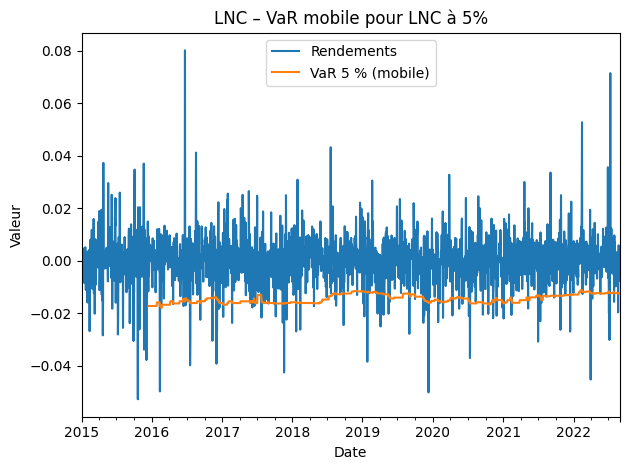

In [ ]:
# b) Calcul de la VaR historique avec fenêtre mobile

def var_historique_mobile(x, alpha=ALPHA, window=ROLLING_WINDOW):
    return x.rolling(window=window, min_periods=window).quantile(alpha)

def violations(x, var_series):
    return (x < var_series).astype(int)

VaR_roll = var_historique_mobile(rendements)
viol_roll = violations(rendements, VaR_roll)

print(f"\n(b) VaR mobile 5% ({ROLLING_WINDOW} j) : "
      f"{viol_roll.sum()} violations sur {viol_roll.count()}  "
      f"({viol_roll.mean():.2%})")

plt.figure()
rendements.plot(label="Rendements")
VaR_roll.plot(label="VaR 5 % (mobile)")
plt.legend()
plt.title(f"{TICKER} – VaR mobile pour LNC à 5%")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


# C) Calcul de la VaR historique avec une fenêtre expansive


(c) VaR expansive 5% (démarrage 250 obs) : 76 violations sur 2000  (3.80%)


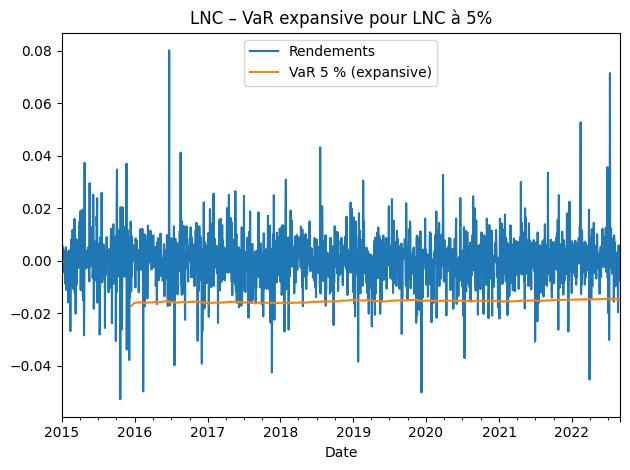

In [49]:
# c) Calcul de la VaR historique avec fenêtre expansive

def var_historique_expansive(x, alpha=ALPHA, min_start=MIN_START):
    out = pd.Series(index=x.index, dtype=float)
    for i in range(len(x)):
        if i + 1 >= min_start:
            out.iloc[i] = np.quantile(x.iloc[:i+1].dropna().values, alpha)
    return out

VaR_exp = var_historique_expansive(rendements)
viol_exp = violations(rendements, VaR_exp)

print(f"\n(c) VaR expansive 5% (démarrage {MIN_START} obs) : "
      f"{viol_exp.sum()} violations sur {viol_exp.count()}  "
      f"({viol_exp.mean():.2%})")

plt.figure()
rendements.plot(label="Rendements")
VaR_exp.plot(label="VaR 5 % (expansive)")
plt.legend()
plt.title(f"{TICKER} – VaR expansive pour LNC à 5%")
plt.xlabel("Date")
plt.tight_layout()
plt.show()
